# 🔄 07 - Weekly Forecast Pipeline: Inputs → Energy Price
This notebook performs a full 1-week energy forecasting pipeline:

1. Recursively forecasts 7 days of input features:
   - Solar, Wind, Load, Irradiance, Temperature, Oil, Gas
2. Uses these as inputs to forecast energy price for the same period
3. Compares predicted price to actual values (from Germany.csv)
4. Outputs MAE, RMSE, and plots for evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load cleaned dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Load full price data for comparison
df_prices = pd.read_csv('../data/raw/Germany.csv', parse_dates=['Datetime (UTC)'])
df_prices.set_index('Datetime (UTC)', inplace=True)
df_prices = df_prices.sort_index()

## 🔁 Recursive Forecast of Input Features (7 Days)

In [2]:
# Forecast horizon
HORIZON = 168  # 7 days
features_to_forecast = [
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal', 
    'DE_temperature'
]

base_history = df.copy().iloc[-900:]
future_inputs = base_history.copy()

input_predictions = {}
for feature in features_to_forecast:
    df_feat = df[[feature]].copy()
    df_feat['lag_1h'] = df_feat[feature].shift(1)
    df_feat['lag_24h'] = df_feat[feature].shift(24)
    df_feat['lag_168h'] = df_feat[feature].shift(168)
    df_feat['roll_24h'] = df_feat[feature].rolling(24).mean()
    df_feat['roll_168h'] = df_feat[feature].rolling(168).mean()
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat.dropna(inplace=True)
    
    model = XGBRegressor(n_estimators=100)
    model.fit(df_feat.drop(columns=[feature]), df_feat[feature])

    preds = []
    history = future_inputs[[feature]].copy()
    for step in range(HORIZON):
        ts = history.index[-1] + timedelta(hours=1)
        row = {
            'lag_1h': history[feature].iloc[-1],
            'lag_24h': history[feature].shift(23).iloc[-1],
            'lag_168h': history[feature].shift(167).iloc[-1],
            'roll_24h': history[feature].rolling(24).mean().iloc[-1],
            'roll_168h': history[feature].rolling(168).mean().iloc[-1],
            'hour': ts.hour,
            'dayofweek': ts.dayofweek,
            'month': ts.month
        }
        row_df = pd.DataFrame([row], index=[ts])
        y_pred = model.predict(row_df)[0]
        row_df[feature] = y_pred
        preds.append(row_df[[feature]])
        history = pd.concat([history, row_df[[feature]]])

    input_predictions[feature] = pd.concat(preds)

## 🔮 Forecast Energy Price Based on Predicted Inputs

In [4]:
# Build dataframe with predicted inputs
future_times = input_predictions['Gas_Price'].index
future_df = pd.DataFrame(index=future_times)
for k, v in input_predictions.items():
    future_df[k] = v[k]

# Add lagged + calendar features based on base price history
price_history = df[['Price (EUR/MWhe)']].iloc[-900:].copy()
price_forecast_input = []

model_data = df[['Price (EUR/MWhe)']].copy()
model_data['lag_1h'] = model_data['Price (EUR/MWhe)'].shift(1)
model_data['lag_24h'] = model_data['Price (EUR/MWhe)'].shift(24)
model_data['lag_168h'] = model_data['Price (EUR/MWhe)'].shift(168)
model_data['hour'] = model_data.index.hour
model_data['dayofweek'] = model_data.index.dayofweek
model_data['month'] = model_data.index.month
model_data = model_data.merge(df[features_to_forecast], left_index=True, right_index=True)
model_data = model_data.dropna()

X = model_data[['lag_1h', 'lag_24h', 'lag_168h', 'hour', 'dayofweek', 'month'] + features_to_forecast]
y = model_data['Price (EUR/MWhe)']

model_price = XGBRegressor(n_estimators=100)
model_price.fit(X, y)

# Forecast price recursively using predicted inputs
future_prices = []
history = price_history.copy()

for ts in future_times:
    row = {
        'lag_1h': history['Price (EUR/MWhe)'].iloc[-1],
        'lag_24h': history['Price (EUR/MWhe)'].shift(23).iloc[-1],
        'lag_168h': history['Price (EUR/MWhe)'].shift(167).iloc[-1],
        'hour': ts.hour,
        'dayofweek': ts.dayofweek,
        'month': ts.month
    }
    for col in features_to_forecast:
        row[col] = future_df.loc[ts, col]

    row_df = pd.DataFrame([row], index=[ts])
    y_pred = model_price.predict(row_df)[0]
    row_df['Price (EUR/MWhe)'] = y_pred
    history = pd.concat([history, row_df[['Price (EUR/MWhe)']]])
    future_prices.append(row_df[['Price (EUR/MWhe)']])

forecast_price_df = pd.concat(future_prices)

## 📊 Evaluation: Compare Forecast vs Actual

MAE: 29.21, RMSE: 37.94


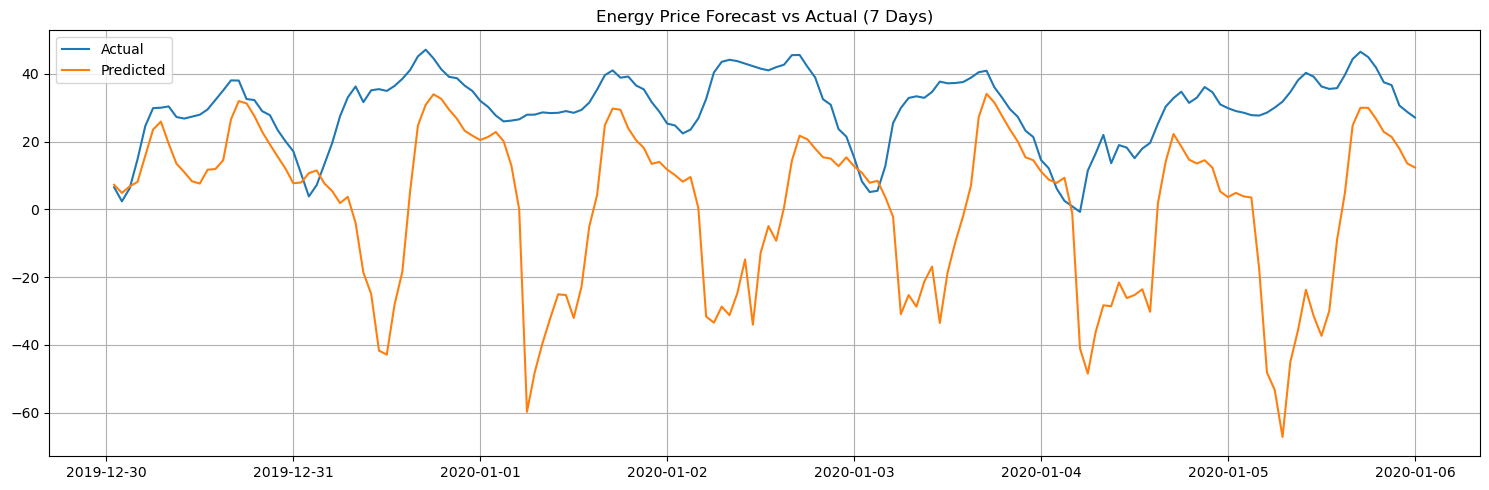

In [5]:
actual_price = df_prices.loc[forecast_price_df.index, 'Price (EUR/MWhe)'].dropna()
compare_df = forecast_price_df.join(actual_price.rename('Actual'))
compare_df.dropna(inplace=True)

mae = mean_absolute_error(compare_df['Actual'], compare_df['Price (EUR/MWhe)'])
rmse = np.sqrt(mean_squared_error(compare_df['Actual'], compare_df['Price (EUR/MWhe)']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(15, 5))
plt.plot(compare_df.index, compare_df['Actual'], label='Actual')
plt.plot(compare_df.index, compare_df['Price (EUR/MWhe)'], label='Predicted')
plt.title('Energy Price Forecast vs Actual (7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tried integrating the method of the 06 notebook but only for a week to see if it is good enough to predict the prices but the results ended up being very bad especially compared to the simple model in notebook 04 </br>
Finished by Jad Akra on Friday 19th of April 2025